# Instabilidade em Modelos Regressores

A análise de regressão nos permite estimar coeficientes em uma função que relaciona aproximadamente vários conjuntos de dados. Nós levantamos a hipótese de uma forma específica para esta função e, em seguida, encontramos coeficientes que se encaixam bem nos dados, trabalhando sob o pressuposto de que os desvios do modelo podem ser considerados ruídos.

Ao construir esse modelo, aceitamos que não podemos prever perfeitamente a variável dependente. Aqui, gostaríamos de avaliar a precisão do modelo, não pelo quão bem ele explica a variável dependente, mas por quão estável é (ou seja, o quão estável são os coeficientes de regressão) em relação à nossa amostra dados. Afinal, se um modelo tiver realmente um bom ajuste, deve ser semelhante, digamos, para duas amostras aleatórias de nosso conjunto de dados, modeladas individualmente. Caso contrário, não podemos assumir que o modelo não é simplesmente um artefato da amostra particular de dados que nós escolhemos (*overfiting*), ou que fará boas previsões para novos pontos de dados.

Usaremos regressões lineares aqui para fins de ilustração, mas as mesmas considerações se aplicam a todos os modelos de regressão. Abaixo, definimos uma função de wrapper para a regressão linear de `statsmodels` para que possamos usá-lo mais tarde.

In [1]:
import numpy as np
import pandas as pd
from statsmodels import regression, stats
import statsmodels.api as sm
import scipy as sp
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

/home/tau/Envs/ds/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def linreg(X,Y):
    # Running the linear regression
    x = sm.add_constant(X) # Add a row of 1's so that our model has a constant term
    model = regression.linear_model.OLS(Y, x).fit()
    return model.params[0], model.params[1] # Return the coefficients of the linear model

# Viés

A amostra particular que escolhemos para os dados afeta o modelo gerado e o ruído distribuído de forma desigual pode levar a um modelo impreciso. Abaixo, amostramos de uma distribuição normal, mas como tomamos poucas amostras, obtemos um significativo desvio para baixo. Se tomarmos mais amostras, ambos os coeficientes de regressão se moveriam em direção a zero.

Slope: 0.009072503822685526 Intercept: -0.40207744085303815


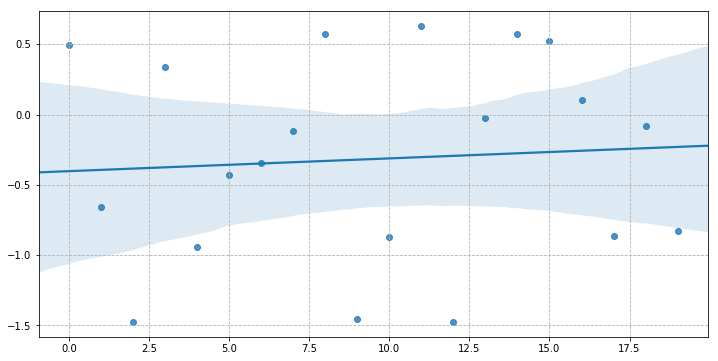

In [3]:
# Draw observations from normal distribution
np.random.seed(107) # Fix seed for random number generation
rand = np.random.randn(20)

# Conduct linear regression on the ordered list of observations
xs = np.arange(20)
a, b = linreg(xs, rand)
print('Slope:', b, 'Intercept:', a)

plt.figure(figsize=(12,6))
plt.grid(linestyle='--')
seaborn.regplot(xs, rand);

Tomando-se mais amostras...

Slope: -0.0005693423631053362 Intercept: 0.009011767319021952


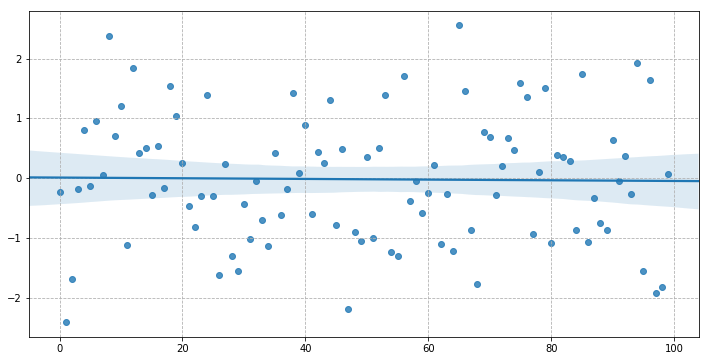

In [4]:
# Draw more observations
rand2 = np.random.randn(100)

# Conduct linear regression on the ordered list of observations
xs2 = np.arange(100)
a2, b2 = linreg(xs2, rand2)
print('Slope:', b2, 'Intercept:', a2)

plt.figure(figsize=(12,6))
plt.grid(linestyle='--')
seaborn.regplot(xs2, rand2);

A regressão linear comum é muito sensível a *outliers*. Às vezes, esses valores pouco comuns contêm informações importantes, caso em que queremos levá-los em conta; no entanto, em casos como o acima, eles podem simplesmente ser ruído.

# Regime dinâmico

Uma mudança de regime (ou ruptura estrutural) é quando algo muda no processo gerador dos dados, fazendo com que futuras amostras sigam uma distribuição diferente. Abaixo, exemplificamos este tipo de evendo utilizando um processo de [Ornstein-Uhlenbeck](https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process) com dois conjuntos de parâmetros diferentes, e a divisão dos dados resulta em um ajuste muito melhor (em vermelho) do que uma regressão em todo o conjunto de dados (amarelo). Nesse caso, nosso modelo de regressão não será preditivo de futuros pontos de dados, já que o sistema subjacente não é mais o mesmo que na amostra. Na verdade, a análise de regressão pressupõe que os erros não estão correlacionados e têm variação constante, o que muitas vezes não é o caso se houver uma mudança de regime.

In [5]:
  class OrnsteinUhlenbeckProcess(object):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=100):
        self.mu = mu
        self.sigma = sigma
        
        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma
        
        self.n_steps = 0
        self.theta = theta
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

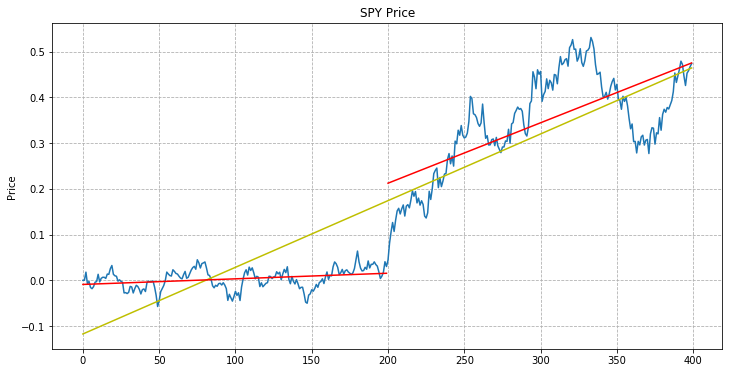

In [6]:
index = np.arange(400)
values = np.zeros(400)

process1 = OrnsteinUhlenbeckProcess(10, sigma=0.1)

for i in index[1:200]:
    values[i] = process1.sample()
    
process2 = OrnsteinUhlenbeckProcess(1, mu=0.6, sigma=0.2, x0=values[i])
    
for i in index[200:]:
    values[i] = process2.sample()

# Manually set the point where we think a structural break occurs
breakpoint = 200
index1 = index2 = np.arange(200)


# Perform linear regressions on the full data set, the data up to the breakpoint, and the data after
a, b = linreg(index, values)
a2, b2 = linreg(index1, values[:breakpoint])
a3, b3 = linreg(index2, values[breakpoint:])

Y_hat = pd.Series(index * b + a, index=index)
Y_hat2 = pd.Series(index1 * b2 + a2, index=index[:breakpoint])
Y_hat3 = pd.Series(index2 * b3 + a3, index=index[breakpoint:])

# Plot the raw data
plt.figure(figsize=(12,6))
plt.plot(values)
Y_hat.plot(color='y')
Y_hat2.plot(color='r')
Y_hat3.plot(color='r')
plt.grid(linestyle='--')
plt.title('SPY Price')
plt.ylabel('Price');

É claro que, quanto mais divisões fizermos em nossos dados, mais preciso será o ajuste que consiguiremos. É importante evitar ajuste no ruído (*overfiting*), que sempre flutuará e não tem poder preditivo. Podemos testar a existência de uma quebra estrutural, seja em um ponto particular que identificamos ou em geral. Abaixo, usamos um teste de `statsmodels` que calcula a probabilidade de observar os dados se não houver ponto de interrupção.

In [7]:
print("Valor-p para quebra de regime:", stats.diagnostic.breaks_cusumolsresid(regression.linear_model.OLS(values, sm.add_constant(index)).fit().resid)[1])

Valor-p para quebra de regime: 1.4763791103335244e-12


# Multicollinearidade

Acima, estávamos considerando apenas regressões de uma variável dependente e uma independente. No entanto, também podemos ter múltiplas variáveis independentes. Isso leva à instabilidade se as variáveis independentes estiverem altamente correlacionadas.

Imagine que estamos usando duas variáveis independentes, $ X_1 $ e $ X_2 $, que são altamente correlacionadas. Então, os coeficientes podem mudar drasticamente se adicionarmos uma nova observação que é ligeiramente melhor explicada por um dos dois do que pelo outro. No caso extremo, se $ X_1 = X_2 $, a escolha dos coeficientes dependerá do algoritmo de regressão linear particular.